### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- many scripts in this notebook com from geemap (see below)

### Tasks
- classify OSM road vectors into different classes (e.g., major and minor roads).
- calculate distance rasters to the vector features.

### Prerequisites
- earth engine api (ee) https://developers.google.com/earth-engine/apidocs
- gee map (gee), https://geemap.org/ by Qiusheng Wu
- create an account and a Google Cloud project in Google Developer, see here: https://developers.google.com/earth-engine/guides/auth

# init

In [4]:
from pathlib import Path
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

from rasterio import features
from scipy.ndimage import distance_transform_edt
import numpy as np
from rasterio.plot import show

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def get_coords(gdf):
    coords = gdf.envelope
    epsg_coords = coords #.crs.to_epsg()
    transform = [coords.bounds.values[0][0], coords.bounds.values[0][1], coords.bounds.values[0][2], coords.bounds.values[0][3]]
    #roi = ee.Geometry.BBox(west=transform[0], south=transform[1], east=transform[2], north=transform[3])
    #rec_roi = ee.Geometry.Rectangle(transform[0],transform[1],transform[2],transform[3])
    #coi = roi.centroid(maxError=1)
    return epsg_coords, transform #roi, rec_roi, coi

# imports

In [6]:
#input a vector and a raster file
AOI_path = Path('../data/processed/')

AOI_file_JAK = 'JAK_LIM_BoundingBox_AOI_A.shp' #Jakarta
AOI_file_MUM = 'MUM_LIM_BoundingBox_AOI_A.shp' #Mumbai
AOI_file_MAN = 'MAN_LIM_BoundingBox_AOI_A.shp' #Manila

#read the vector files
AOI_gdf_JAK = gpd.read_file(AOI_path/AOI_file_JAK).to_crs(epsg=32748)
AOI_gdf_MUM = gpd.read_file(AOI_path/AOI_file_MUM).to_crs(epsg=32643)
AOI_gdf_MAN = gpd.read_file(AOI_path/AOI_file_MAN).to_crs(epsg=32651)

print(AOI_gdf_JAK.crs, AOI_gdf_MUM.crs, AOI_gdf_MAN.crs)

EPSG:32748 EPSG:32643 EPSG:32651


In [8]:
# import OSM vector data
roads_path = Path('D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\')
JAK_roads = gpd.read_file(roads_path/'JAK_TRA_roads_OSM_2024_L.shp')
MUM_roads = gpd.read_file(roads_path/'MUM_TRA_roads_OSM_2024_L.shp')
MAN_roads = gpd.read_file(roads_path/'MAN_TRA_roads_OSM_2024_L.shp')
print(JAK_roads.crs, MUM_roads.crs, MAN_roads.crs)

EPSG:32748 EPSG:32643 EPSG:32651


In [9]:
JAK_ref_raster = rasterio.open(roads_path/'JAK_DEM_slope_TanDEM_X_30m.tif', 'r')
MUM_ref_raster = rasterio.open(roads_path/'MUM_DEM_slope_TanDEM_X_30m.tif', 'r')
MAN_ref_raster = rasterio.open(roads_path/'Man_DEM_slope_TanDEM_X_30m.tif', 'r')
print(JAK_ref_raster.crs, MUM_ref_raster.crs, MAN_ref_raster.crs)

EPSG:32748 EPSG:32643 EPSG:32651


# analysis

In [10]:
# classify the roads into major and minor
JAK_roads['major'] = JAK_roads['highway'].apply(lambda x: 1 if x in ['primary', 'secondary'] else 0) 
MUM_roads['major'] = MUM_roads['highway'].apply(lambda x: 1 if x in ['primary', 'secondary'] else 0)
MAN_roads['major'] = MAN_roads['highway'].apply(lambda x: 1 if x in ['primary', 'secondary'] else 0)

In [72]:
# Load roads data for one of the cities
global distance_raster_file
global major_road_raster_file
global full_road_raster_file

city = input('Choose the city: 1  = Jakarta, 2 = Mumbai, 3 = Manila')
if city == '1':
    roads_gdf = JAK_roads
    distance_raster_file = 'JAK_TRA_distance_to_major_roads.tif'
    major_road_raster_file = 'JAK_TRA_major_roads_OSM_2024.tif'
    full_road_raster_file = 'JAK_TRA_all_roads_OSM_2024.tif'
    ref_raster = JAK_ref_raster
elif city == '2':
    roads_gdf = MUM_roads
    distance_raster_file = 'MUM_TRA_distance_to_major_roads.tif'
    major_road_raster_file = 'MUM_TRA_major_roads_OSM_2024.tif'
    full_road_raster_file = 'MUM_TRA_all_roads_OSM_2024.tif'
    ref_raster = MUM_ref_raster
elif city == '3':
    roads_gdf = MAN_roads.to_crs(epsg=4326)
    distance_raster_file = 'MAN_TRA_distance_to_major_roads.tif'
    major_road_raster_file = 'MAN_TRA_major_roads_OSM_2024.tif'
    full_road_raster_file = 'MAN_TRA_all_roads_OSM_2024.tif'
    ref_raster = MAN_ref_raster


# Filter roads where major == 1
major_roads_gdf = roads_gdf[roads_gdf['major'] == 1]

# Get the geometry of the major roads
major_geom = [shapes for shapes in major_roads_gdf.geometry]

# Rasterize the major roads, script from https://pygis.io/docs/e_raster_rasterize.html
major_roads_raster = features.rasterize(major_geom,
                                out_shape = ref_raster.shape,
                                fill = 0,
                                out = None,
                                transform = ref_raster.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)

# Get the geometry of the all roads
full_geom = [shapes for shapes in roads_gdf.geometry]

# Rasterize the all roads, script from https://pygis.io/docs/e_raster_rasterize.html
full_roads_raster = features.rasterize(full_geom,
                                out_shape = ref_raster.shape,
                                fill = 0,
                                out = None,
                                transform = ref_raster.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)

# Invert the raster: roads (value == 1) become 0, non-roads become 1
#inverted_roads_raster = np.where(major_roads_raster == 1, 0, 1)

# Calculate the distance to the nearest road for each cell
#distance_to_roads = distance_transform_edt(inverted_roads_raster)
# Assuming the raster's resolution is in meters, the distance_to_roads array now contains the distance in meters to the nearest road for each cell

In [73]:
full_geom

[<MULTILINESTRING ((334634.144 2041903.113, 334666.173 2041938.863, 334691.41...>,
 <LINESTRING (330330.226 2051131.557, 330339.122 2051129.983)>,
 <LINESTRING (330456.336 2051298.597, 330429.669 2051324.724)>,
 <LINESTRING (331168.398 2052847.55, 331170.347 2052875.669, 331175.626 20528...>,
 <LINESTRING (331083.79 2054565.753, 331067.115 2054571.922, 331050.283 20545...>,
 <LINESTRING (331041.261 2054594.113, 331036.728 2054593.589, 331022.61 20545...>,
 <LINESTRING (331041.261 2054594.113, 331047.714 2054619.38, 331056.498 20546...>,
 <LINESTRING (331162.356 2056369.261, 331267.016 2056358.755, 331273.193 2056...>,
 <LINESTRING (330541.879 2057748.376, 330540.45 2057745.577, 330539.52 205774...>,
 <LINESTRING (330643.715 2057768.75, 330646.813 2057753.99, 330648.618 205774...>,
 <LINESTRING (329707.091 2045601.611, 329720.245 2045615.296, 329726.268 2045...>,
 <LINESTRING (328553.141 2048754.105, 328556.097 2048767.029, 328555.735 2048...>,
 <LINESTRING (328563.106 2049230.888, 3285

In [74]:
major_roads_raster = features.rasterize(major_geom,
                                out_shape = ref_raster.shape,
                                fill = 0,
                                out = None,
                                transform = ref_raster.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)
inverted_roads_raster = np.where(major_roads_raster == 1, 0, 1)
print(inverted_roads_raster.min(), inverted_roads_raster.max())

0 1


In [54]:
ref_raster.transform

Affine(30.21610524132209, 0.0, 228159.65590334672,
       0.0, -30.476992707857995, 1684836.8629805148)

<Axes: >

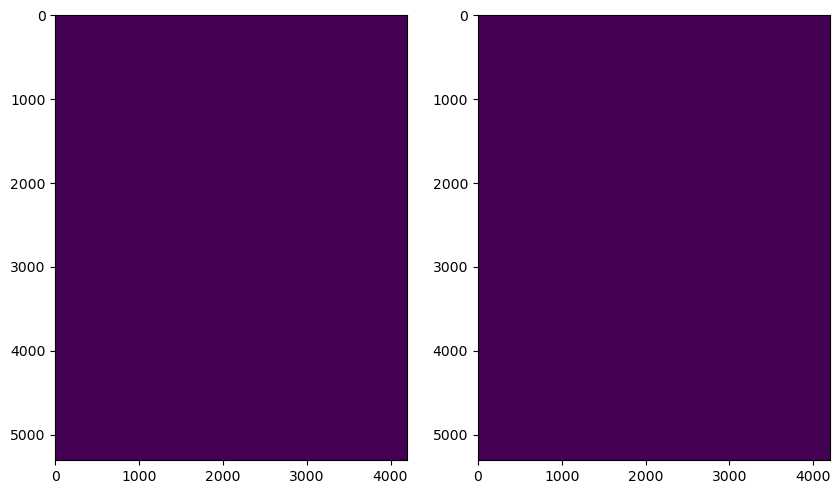

In [52]:
# Plot the three rasters
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (10, 30))
show(major_roads_raster, ax = ax[0])
show(full_roads_raster, ax = ax[1])
#show(distance_to_roads, ax = ax[2],cmap='viridis')

plt.gca() 

# export

In [42]:
# define two export functions
# export rasters as geotiff
def export_raster(raster,url):
    with rasterio.open(
        url, "w",
        driver = "GTiff",
        crs = ref_raster.crs,
        transform = ref_raster.transform,
        dtype = rasterio.float32,
        count = 1,
        width = ref_raster.width,
        height = ref_raster.height) as dst:
        dst.write(raster, indexes = 1)

# export raster as ascii files
def export_raster_to_ascii(raster_obj, export_path, raster_data_type):
    with rasterio.open(export_path, "w", driver='AAIGrid',
                    height = ref_raster.shape[0], width=ref_raster.shape[1],
                    count=1, dtype=list(ref_raster.dtypes)[0],
                    crs=ref_raster.crs, transform = ref_raster.transform) as dest:
        dest.write(raster_obj.astype(raster_data_type), indexes=1)

In [44]:
# export the calculated arrays as raster files in geotiff format
out_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\')
distance_url = out_path/distance_raster_file
major_roads_url = out_path/major_road_raster_file
full_roads_url = out_path/full_road_raster_file

export_raster(distance_to_roads,distance_url)
export_raster(major_roads_raster,major_roads_url)
export_raster(full_roads_raster,full_roads_url)

In [45]:
# export the calculated arrays as ASCII files
# define the ASCII file names
out_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\CityCell\\')

distance_ascii_url = out_path/(distance_raster_file.split('.')[0] + '.asc')
major_roads_ascii_url = out_path/(major_road_raster_file.split('.')[0] + '.asc')
full_roads_ascii_url = out_path/(full_road_raster_file.split('.')[0] + '.asc')

# call the ASCII export function
export_raster_to_ascii(distance_to_roads, distance_ascii_url,rasterio.float32)
export_raster_to_ascii(major_roads_raster, major_roads_ascii_url,rasterio.int16)
export_raster_to_ascii(full_roads_raster, full_roads_ascii_url,rasterio.int16)
